In [11]:
import tensorflow as tf
import keras
import os
import sys
import numpy as np
import segmentation_models as sm
import csv
import medpy.metric.binary as med
# custom loss
import custom_loss as custom
import loss_functions as lossF
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

DATA_DIR = '/home/intern/data/data_liverbound_noclip/'
WEIGHT_DIR = './Train_Val_Test_data/saved_weights/'
LIVER_DIR = './Train_Val_Test_data/evaluation/eval_liver/'
RES_DIR = './Train_Val_Test_data/evaluation/'

# Input Data
livers = [LIVER_DIR+x for x in os.listdir(LIVER_DIR)]
livers.sort()

In [5]:
def get_model(img_shape=[None, None]):
    sm.set_framework('keras')
    
    model_seg = sm.Unet(input_shape=img_shape + [5],
                       classes = 1,
                       activation='sigmoid',
                       encoder_weights=None,
                       backbone_name='resnet34',
                       decoder_block_type='transpose',
                       )
    
    inp_all = keras.layers.Input(shape=img_shape + [5], name='input_seg')

    predictions = model_seg(inp_all)
    model = keras.Model(inputs=[inp_all], outputs=predictions)
    
    return model, model_seg

def load_model(model_name, model_loss):
    model, _ = get_model()
    LR = 1e-3
    model.compile(optimizer = keras.optimizers.Adam(LR),
                     loss = model_loss,
                     metrics=[sm.metrics.FScore(per_image=False, name='Dice')])
    model.load_weights(WEIGHT_DIR + model_name + '_lesion.ckpt')
    
    return model

In [ ]:
def show_prediction_10(vol, slide, model):
    for i in range(10):
        pred = model.predict(liver[np.newaxis,:,:,slide+i:slide+i+5])
        plt.figure(figsize=(15,5))
        plt.subplot(131)
        plt.imshow(np.clip(liver_gt[...,slide+i+4], -200, 200), cmap='gray')
        plt.subplot(132)
        plt.imshow(seg_gt[...,slide+i+4]==2, cmap='gray')
        plt.subplot(133)
        plt.imshow(pred[0,...], cmap='gray')


def show_pred_models(vol, slide):
    plt.figure(figsize=(35, 5))
    plt.subplot(1, len(models),1)
    plt.imshow(np.clip(liver_gt[...,slide+4], -200, 200), cmap='gray')
    plt.subplot(1, len(models),2)
    plt.imshow(seg_gt[...,slide+4]==2, cmap='gray')
    
    for model, i in enumerate(models):
        pred = model.predict(liver[np.newaxis,:,:,slide:slide+5])
        plt.subplot(1,len(models),i+2)
        plt.imshow(pred[0,...], cmap='gray')

In [148]:
models = list()
models.append(load_model('BCE', sm.losses.BinaryCELoss()))
models.append(load_model('WBCE07', custom.WeightedBCE(alpha=0.7)))
models.append(load_model('Dice',sm.losses.DiceLoss()))
models.append(load_model('Tver07', custom.TverskyLoss(alpha=0.7)))
models.append(load_model('Tverfocal07', custom.TverskyFocalLoss(alpha=0.7)))
models.append(load_model('Combo', lossF.combo_loss(alpha=0.5, beta=0.5)))
models.append(load_model('HybridFocal',lossF.hybrid_focal_loss(alpha=0.25)))

In [151]:
vol = '125'
slide = 50

liver_gt = np.load(DATA_DIR+'volume-{}.npy'.format(vol))
seg_gt = np.load(DATA_DIR+'segmentation-{}.npy'.format(vol))
liver = np.load(livers[0].replace('0', vol))


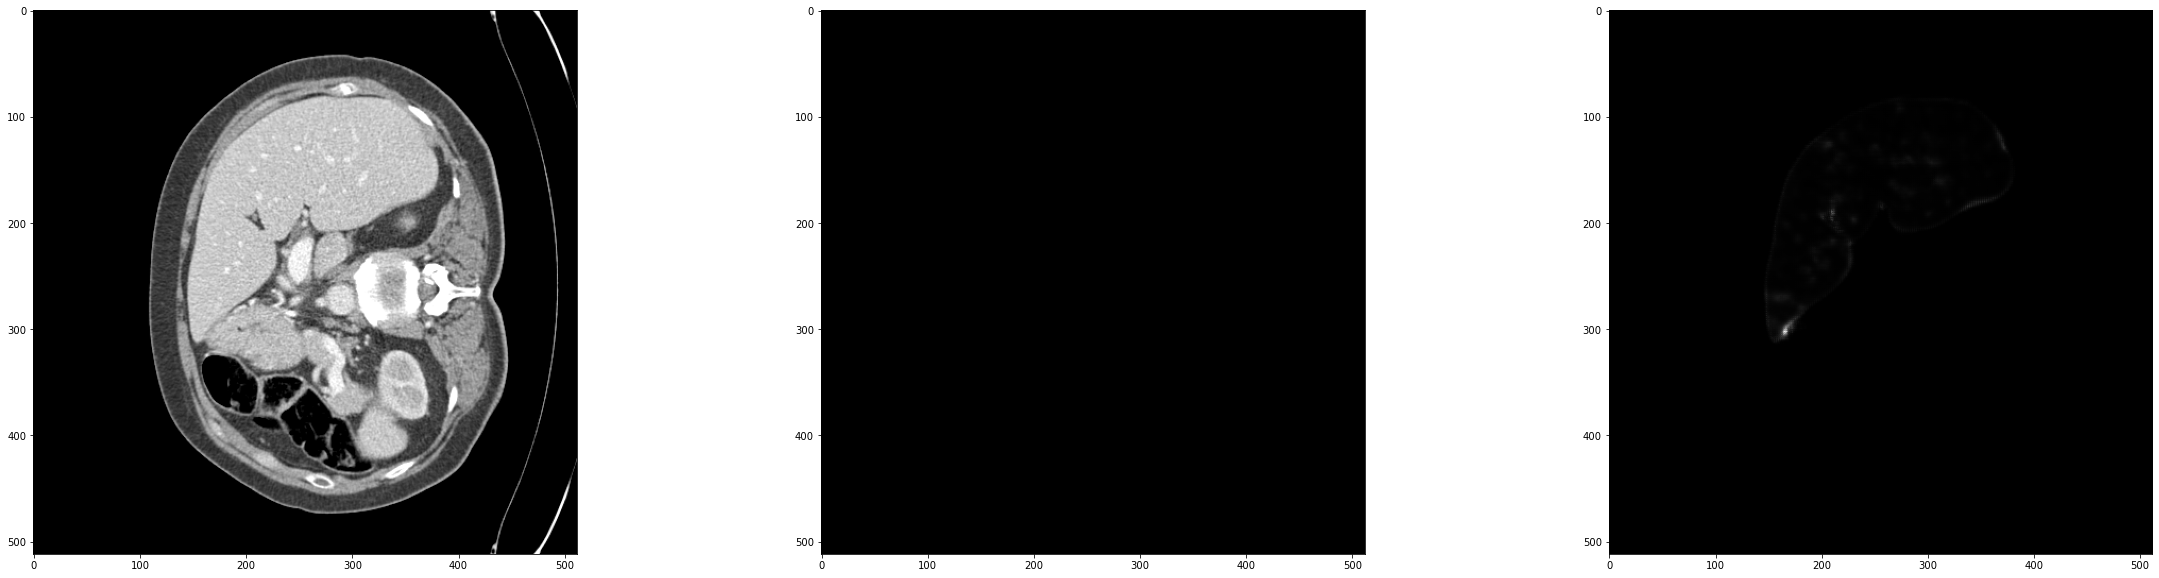

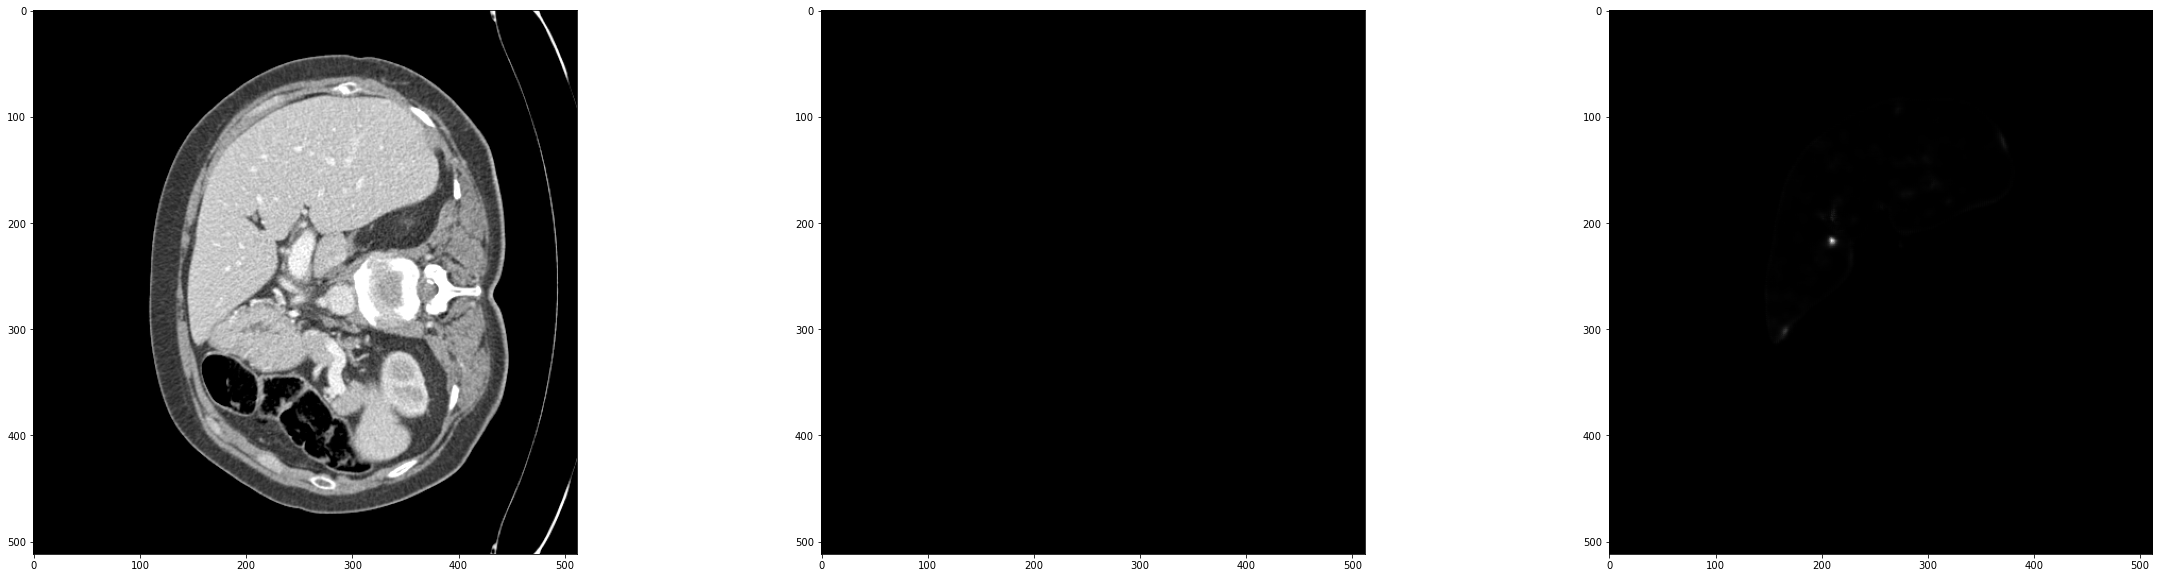

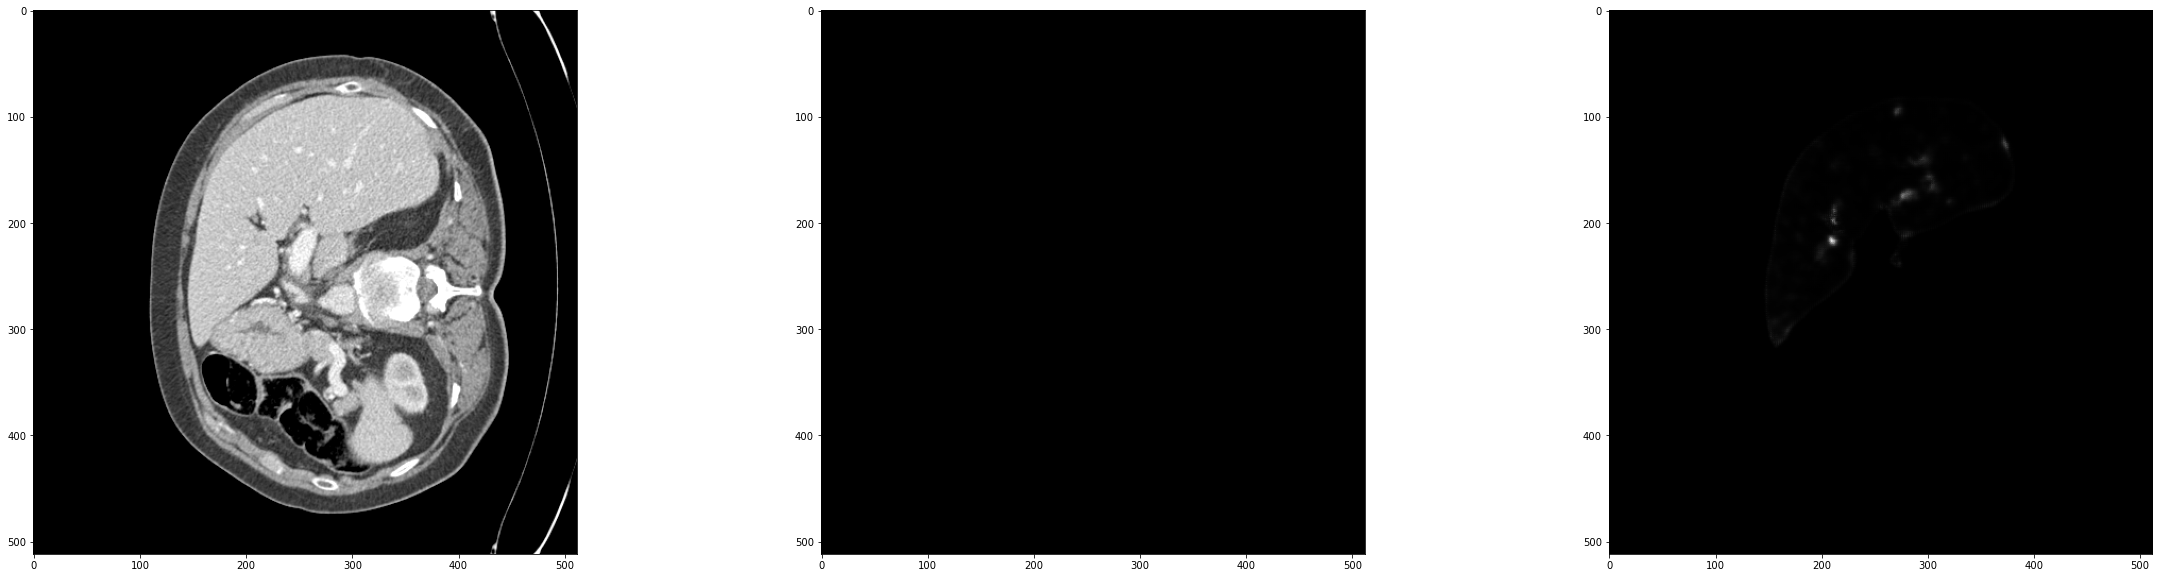

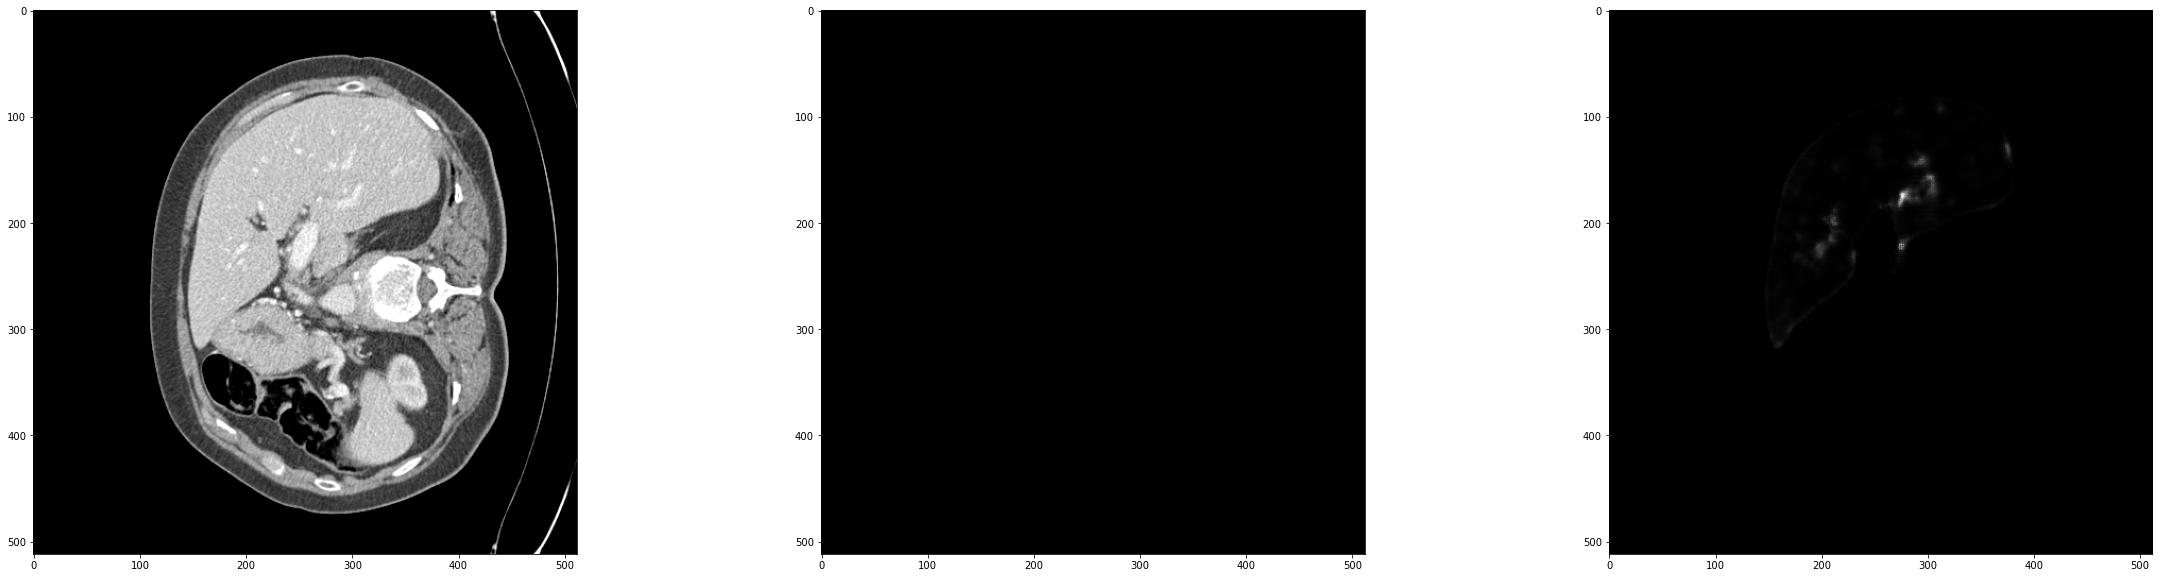

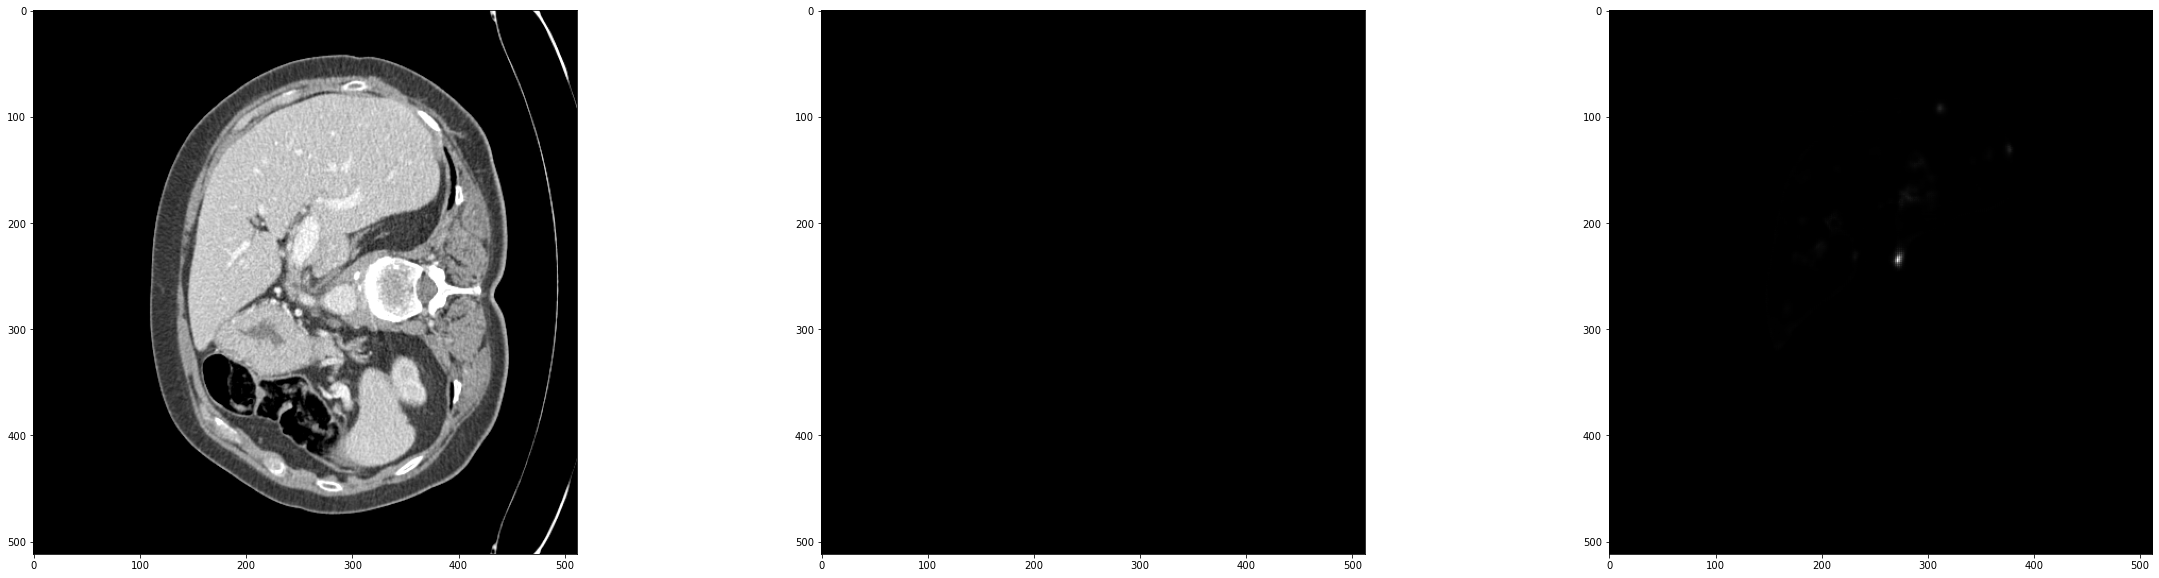

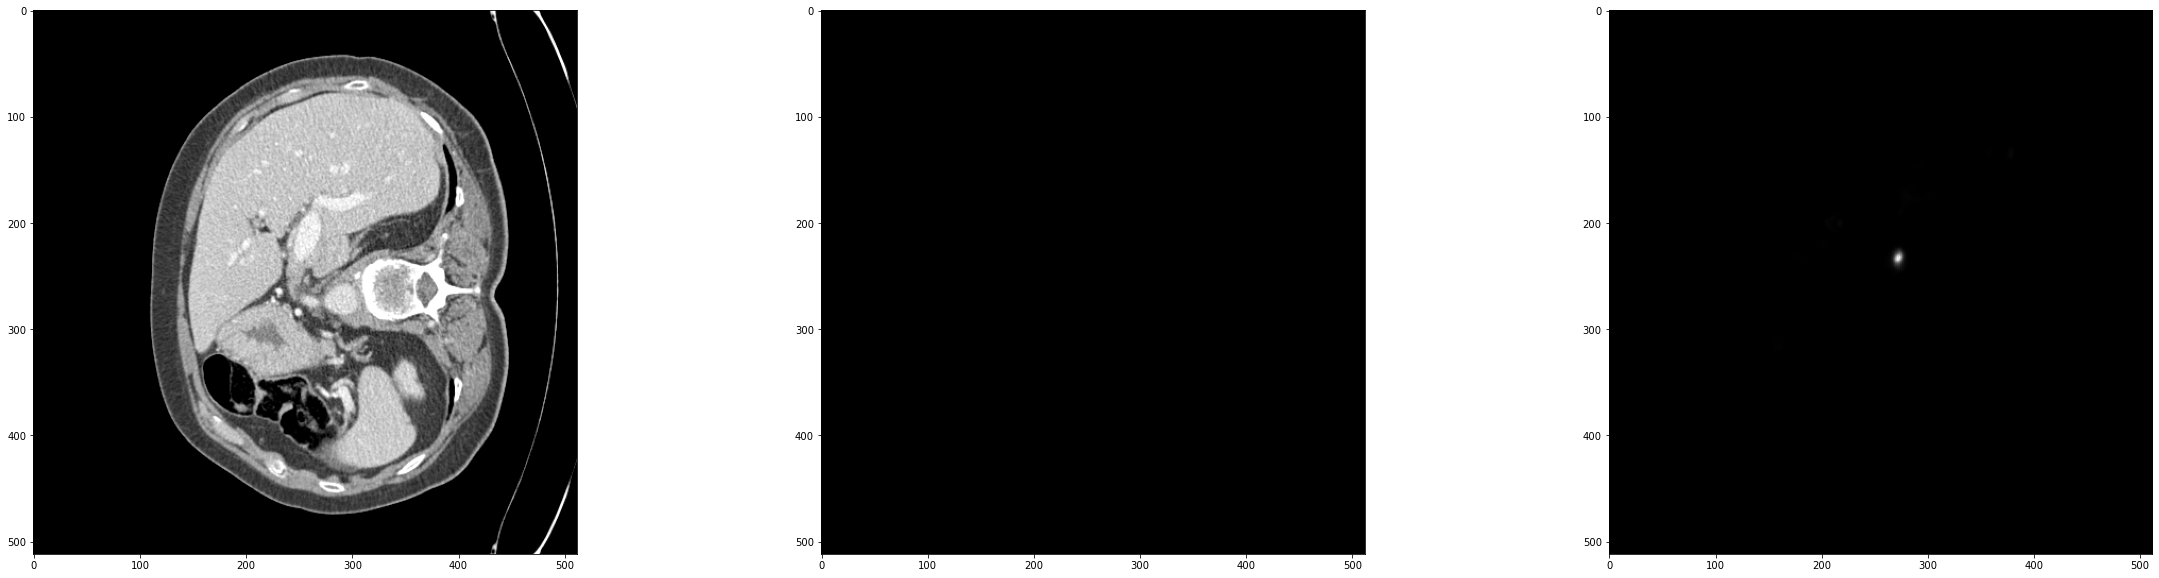

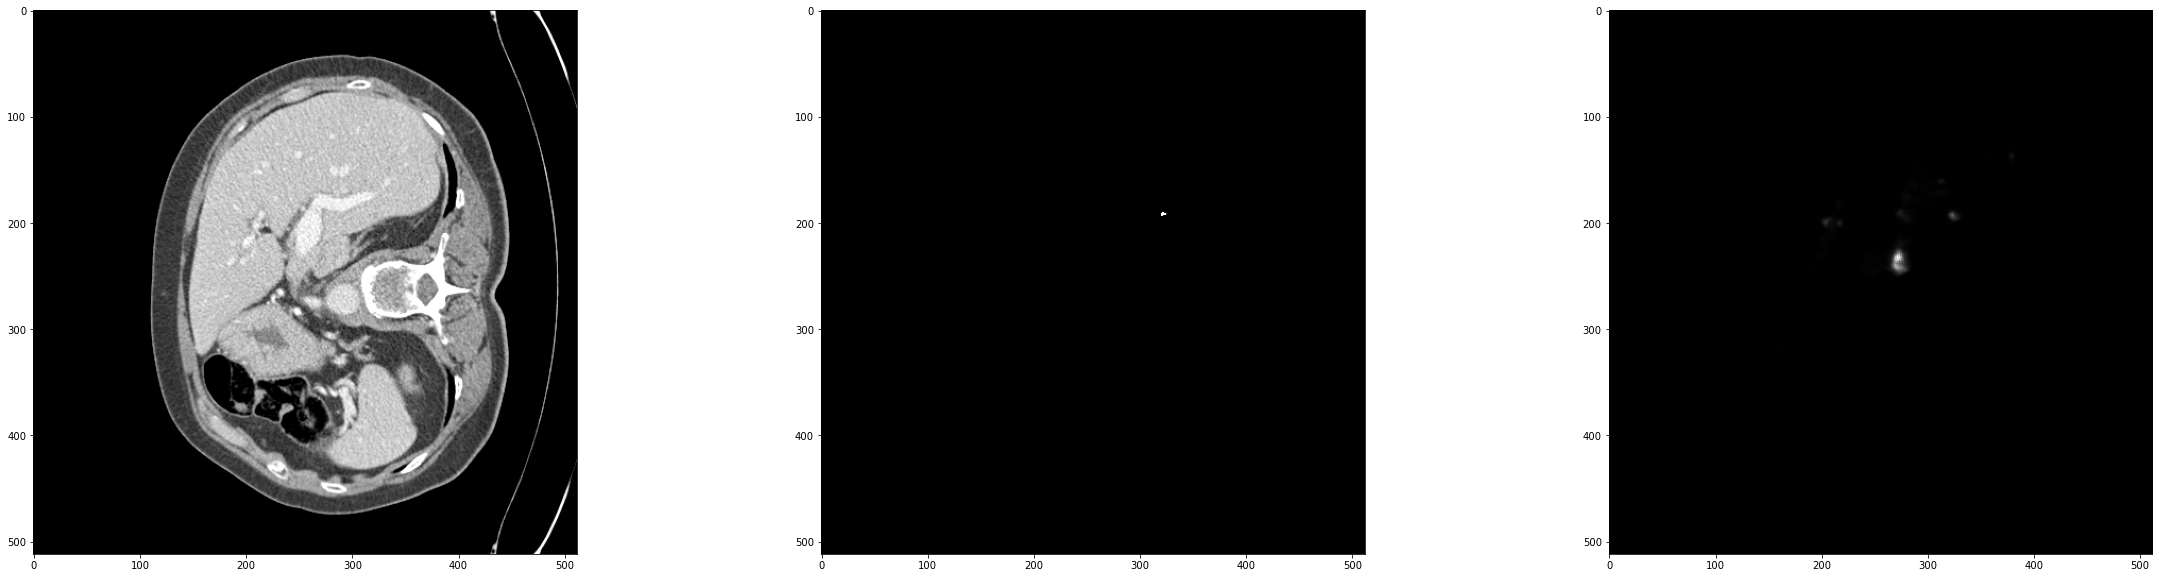

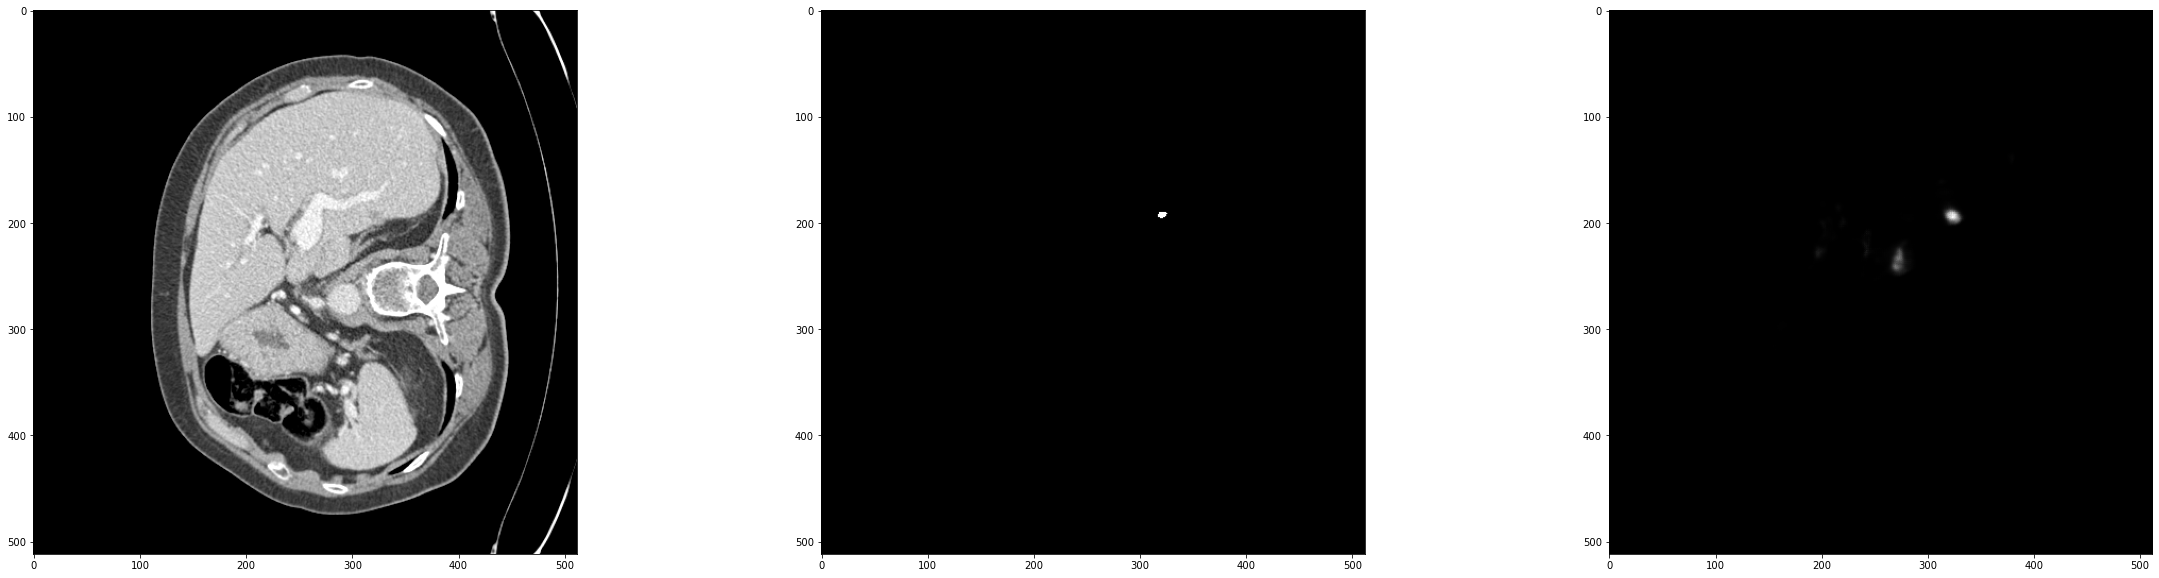

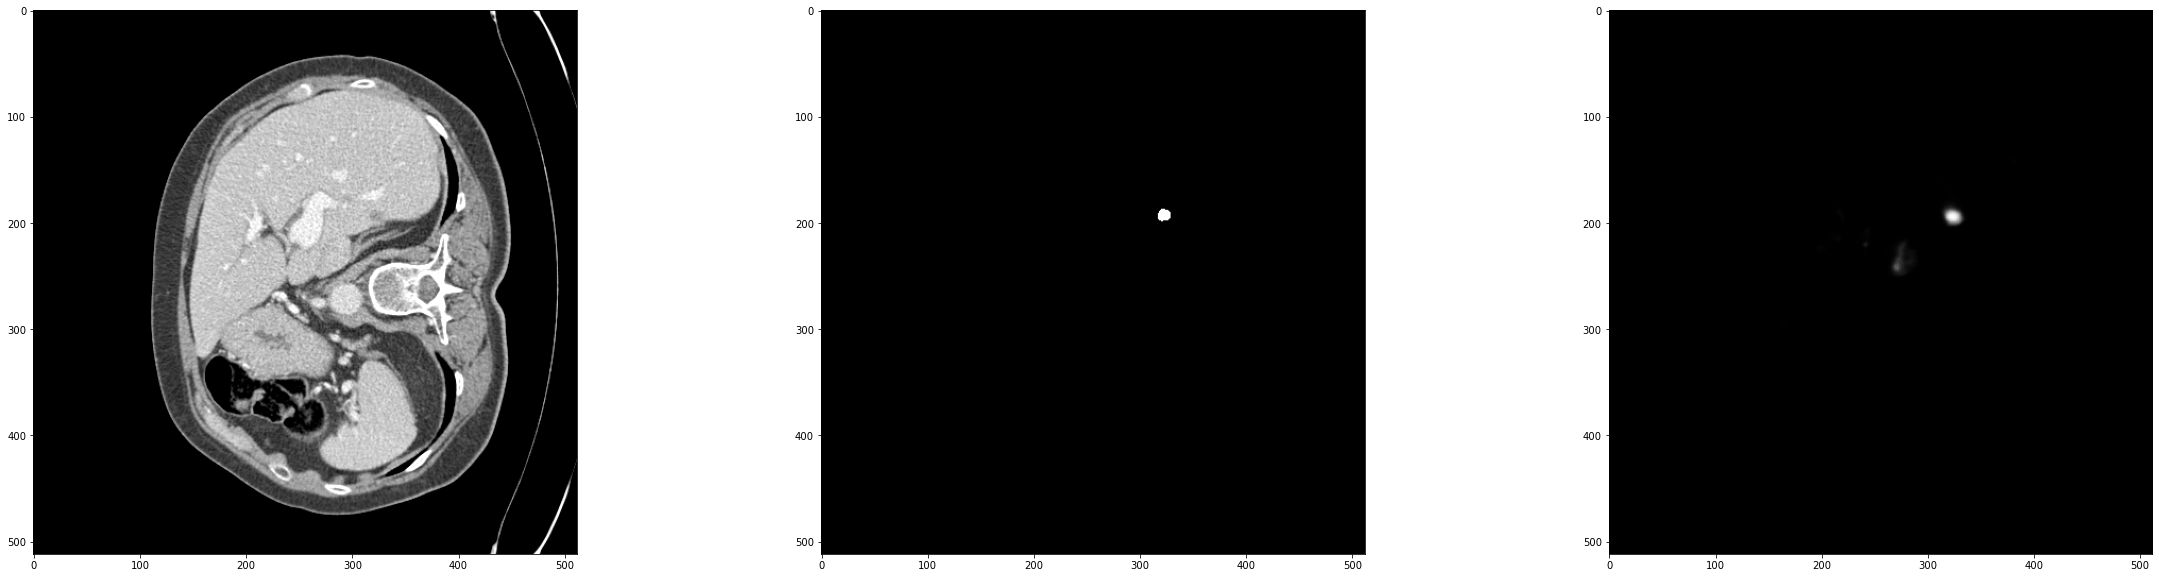

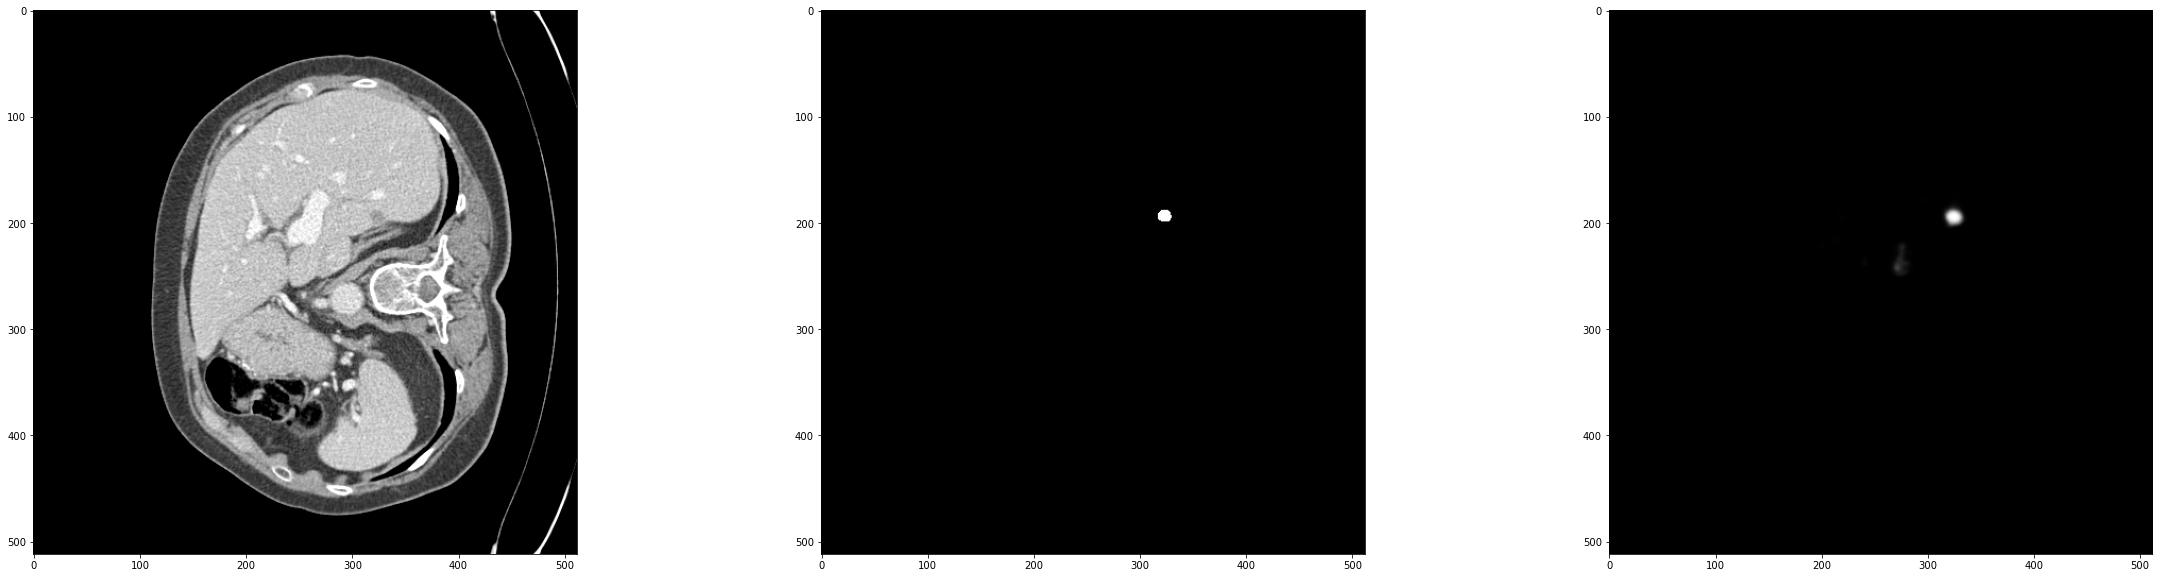

In [152]:
show_prediction_10(vol, slide)